# Прогнозирование большого количества рядов

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок

1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D, Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!
6. Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
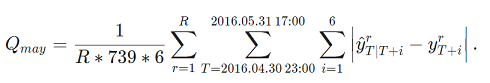
7. Для каждой из RR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.
8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.
9. Загрузите ноутбук в форму.

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler as scaler
from itertools import product
import datetime

In [2]:
import warnings
warnings.simplefilter(action='ignore')

**Замечание:** Метод `sklearn.cluster KMeans` не всегда корректно работает при версии `numpy` старше 1.21.4. Если вы столкнетесь с таким, имеет смысл откатить версию numpy до 1.21.4. 

In [3]:
#np.__version__

In [4]:
#!pip install --upgrade numpy==1.21.4

###  Задание 1


In [5]:
nonzero_reg=pd.read_csv("nonzero_regions.csv").iloc[:,1]
nonzero_reg

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: 0, Length: 102, dtype: int64

In [6]:
df_3=pd.read_csv("taxi_2016_03.csv")
df_4=pd.read_csv("taxi_2016_04.csv")
df_2=pd.read_csv("taxi_2016_02.csv")
df_1=pd.read_csv("taxi_2016_01.csv")
data=pd.concat([ df_1,df_2,df_3,df_4], axis=0)

In [7]:
data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
data.index=data.time
df=data.iloc[:,nonzero_reg]
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0
2016-01-01 03:00:00,32.0,87.0,16.0,62.0,252.0,399.0,324.0,309.0,327.0,166.0,...,46.0,0.0,2.0,4.0,5.0,1.0,0.0,21.0,0.0,9.0
2016-01-01 04:00:00,24.0,43.0,10.0,53.0,145.0,254.0,264.0,333.0,318.0,145.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,6.0


In [92]:
df.values.mean()

151.7629334791768

In [8]:
reg_index=[int(x) for x in nonzero_reg]

In [9]:
# ваш код


###  Задание 2


In [10]:
sc=scaler()
df_s=pd.DataFrame(sc.fit_transform(X=np.array(df)), columns=df.columns)
df_s

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
0,0.534333,0.178299,-0.565388,0.271055,1.423610,0.941333,1.327688,1.324958,1.906912,1.834977,...,1.551231,-0.883705,-0.571914,-1.047780,-1.251905,-0.786766,-0.681902,-0.821275,-0.855714,0.031380
1,0.823393,1.005639,-0.582598,1.673853,2.292927,1.069294,0.407607,0.529828,0.846918,1.255230,...,5.252950,-0.883705,-0.069239,-1.325716,-1.275832,-1.423829,-1.172000,-1.125258,-1.089383,-0.931147
2,0.797115,0.202995,-1.030077,1.083201,2.180427,1.104839,0.081865,0.108021,-0.065856,0.095738,...,9.172418,-0.883705,-0.404356,-1.338951,-1.259881,-1.492701,-1.172000,-0.834492,-1.089383,-1.321360
3,-0.727022,-0.525558,-1.150552,-0.098103,0.738384,0.920006,0.144727,-0.168335,-0.276172,0.473247,...,8.954670,-0.883705,-0.571914,-1.312481,-1.251905,-1.475483,-1.172000,-1.468890,-1.128328,-1.451432
4,-0.937247,-1.068886,-1.253817,-0.319598,-0.355932,-0.110791,-0.198160,-0.051975,-0.314029,0.190115,...,8.301425,-0.883705,-0.907031,-1.332334,-1.283807,-1.492701,-1.172000,-1.402807,-1.089383,-1.529474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899,1.611740,0.980942,1.069631,0.861707,1.689519,1.247018,1.259110,1.843733,1.784929,1.524880,...,-0.843999,-0.883705,-0.069239,-0.333085,-0.629819,0.917809,-0.559377,0.341789,1.169419,0.499636
2900,1.243845,0.968594,0.277938,1.009370,1.127020,1.005314,1.396265,1.887368,1.881674,1.066476,...,-0.626251,-0.883705,-0.571914,-0.405878,-0.964789,0.556233,0.175771,1.319821,0.818915,1.436149
2901,0.823393,0.314131,0.432834,1.206254,1.413383,1.374979,1.722008,2.575834,1.843817,0.284492,...,-0.626251,-0.883705,-0.571914,-0.081619,-0.757427,0.728412,0.788394,0.341789,2.026206,1.358106
2902,1.059897,-0.402074,0.036988,0.837096,0.380430,1.076403,2.276342,2.963703,2.171911,0.972098,...,-0.843999,-0.883705,-0.571914,0.183083,-0.653746,0.780066,1.401017,0.870455,-0.232596,0.733765


In [11]:
df_t=df_s.transpose()
df_t

,0,1,2,3,4,5,6,7,8,9,...,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903
1075,0.534333,0.823393,0.797115,-0.727022,-0.937247,-1.278864,-1.383977,-1.331421,-1.094917,-0.989804,...,2.058469,2.242417,2.689147,2.163582,2.557756,1.611740,1.243845,0.823393,1.059897,0.849671
1076,0.178299,1.005639,0.202995,-0.525558,-1.068886,-1.377595,-1.291156,-1.291156,-1.278808,-1.130628,...,2.326913,2.092295,1.042684,1.289651,1.153819,0.980942,0.968594,0.314131,-0.402074,-0.142759
1077,-0.565388,-0.582598,-1.030077,-1.150552,-1.253817,-1.339870,-1.374292,-1.253817,-1.271027,-1.133342,...,1.052420,1.104052,0.501677,0.484466,0.708206,1.069631,0.277938,0.432834,0.036988,-0.341648
1125,0.271055,1.673853,1.083201,-0.098103,-0.319598,-1.205576,-1.205576,-1.254797,-1.131744,-0.910250,...,0.615602,0.615602,0.221834,0.763265,1.107812,0.861707,1.009370,1.206254,0.837096,0.492549
1126,1.423610,2.292927,2.180427,0.738384,-0.355932,-1.307067,-1.440022,-1.409340,-1.122977,-1.153658,...,1.116792,1.096338,0.861111,1.556564,1.628155,1.689519,1.127020,1.413383,0.380430,1.065656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,-0.786766,-1.423829,-1.492701,-1.475483,-1.492701,-0.907291,-0.907291,-0.425189,-0.666240,-0.976163,...,1.503219,1.193296,1.089989,1.709834,0.745630,0.917809,0.556233,0.728412,0.780066,0.814502
2069,-0.681902,-1.172000,-1.172000,-1.172000,-1.172000,-0.804427,-0.559377,0.175771,0.053246,-1.172000,...,0.420820,0.543344,0.665869,0.910918,-0.191803,-0.559377,0.175771,0.788394,1.401017,0.053246
2118,-0.821275,-1.125258,-0.834492,-1.468890,-1.402807,-0.781625,-0.556942,-0.781625,-1.045958,-1.019525,...,0.830805,1.095138,0.962972,1.266954,0.288923,0.341789,1.319821,0.341789,0.870455,0.645772
2119,-0.855714,-1.089383,-1.089383,-1.128328,-1.089383,-1.089383,-0.816769,-0.699935,-0.855714,-0.466266,...,1.558868,1.831482,0.585246,3.077717,0.546301,1.169419,0.818915,2.026206,-0.232596,1.753592


###  Задание 3


In [62]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering

In [65]:
clustering = AgglomerativeClustering(n_clusters=5).fit(df_t)
clustering

AgglomerativeClustering(n_clusters=5)

In [66]:
clustering.labels_

array([3, 3, 3, 0, 0, 0, 0, 2, 2, 0, 3, 4, 4, 4, 4, 2, 2, 2, 0, 0, 3, 4,
       4, 3, 2, 2, 2, 4, 4, 2, 2, 2, 0, 0, 0, 0, 3, 3, 2, 2, 2, 4, 3, 3,
       0, 0, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 2, 2, 2,
       0, 3, 3, 3, 3, 4, 4, 4, 4, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Оптимальное количество кластеров: 3


Text(0, 0.5, 'Внутриклассовый разброс')

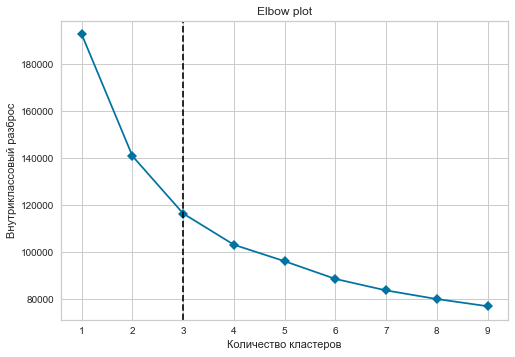

In [13]:
kmeans = KMeans(random_state=1)
kmeans_vis = KElbowVisualizer(kmeans, k=(1,10),  timings=False).fit(df_t)
print('Оптимальное количество кластеров:', kmeans_vis.elbow_value_)
plt.title('Elbow plot')
plt.xlabel('Количество кластеров')
plt.ylabel('Внутриклассовый разброс')

Оптимальное количество кластеров: 2


Text(0, 0.5, 'silhouette')

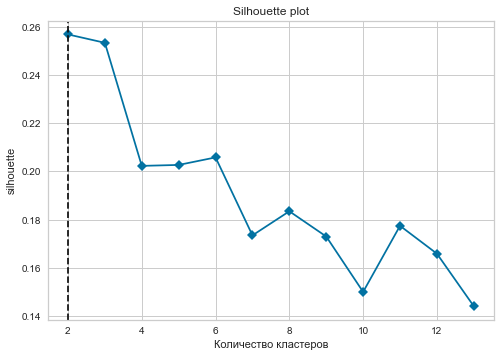

In [14]:
kmeans = KMeans(random_state=1)
kmeans_vis = KElbowVisualizer(kmeans, k=(2,14), metric='silhouette', timings=False).fit(df_t)
print('Оптимальное количество кластеров:', kmeans_vis.elbow_value_)
plt.title('Silhouette plot')
plt.xlabel('Количество кластеров')
plt.ylabel('silhouette')

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(df_t)

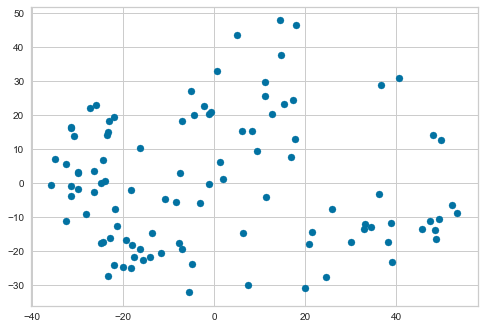

In [33]:
plt.scatter(XPCAreduced[:, 0], XPCAreduced[:, 1])

,0,1,2,3,4,5,6,7,8,9,...,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903
1075,0.534333,0.823393,0.797115,-0.727022,-0.937247,-1.278864,-1.383977,-1.331421,-1.094917,-0.989804,...,2.058469,2.242417,2.689147,2.163582,2.557756,1.611740,1.243845,0.823393,1.059897,0.849671
1076,0.178299,1.005639,0.202995,-0.525558,-1.068886,-1.377595,-1.291156,-1.291156,-1.278808,-1.130628,...,2.326913,2.092295,1.042684,1.289651,1.153819,0.980942,0.968594,0.314131,-0.402074,-0.142759
1077,-0.565388,-0.582598,-1.030077,-1.150552,-1.253817,-1.339870,-1.374292,-1.253817,-1.271027,-1.133342,...,1.052420,1.104052,0.501677,0.484466,0.708206,1.069631,0.277938,0.432834,0.036988,-0.341648
1125,0.271055,1.673853,1.083201,-0.098103,-0.319598,-1.205576,-1.205576,-1.254797,-1.131744,-0.910250,...,0.615602,0.615602,0.221834,0.763265,1.107812,0.861707,1.009370,1.206254,0.837096,0.492549
1126,1.423610,2.292927,2.180427,0.738384,-0.355932,-1.307067,-1.440022,-1.409340,-1.122977,-1.153658,...,1.116792,1.096338,0.861111,1.556564,1.628155,1.689519,1.127020,1.413383,0.380430,1.065656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,-0.786766,-1.423829,-1.492701,-1.475483,-1.492701,-0.907291,-0.907291,-0.425189,-0.666240,-0.976163,...,1.503219,1.193296,1.089989,1.709834,0.745630,0.917809,0.556233,0.728412,0.780066,0.814502
2069,-0.681902,-1.172000,-1.172000,-1.172000,-1.172000,-0.804427,-0.559377,0.175771,0.053246,-1.172000,...,0.420820,0.543344,0.665869,0.910918,-0.191803,-0.559377,0.175771,0.788394,1.401017,0.053246
2118,-0.821275,-1.125258,-0.834492,-1.468890,-1.402807,-0.781625,-0.556942,-0.781625,-1.045958,-1.019525,...,0.830805,1.095138,0.962972,1.266954,0.288923,0.341789,1.319821,0.341789,0.870455,0.645772
2119,-0.855714,-1.089383,-1.089383,-1.128328,-1.089383,-1.089383,-0.816769,-0.699935,-0.855714,-0.466266,...,1.558868,1.831482,0.585246,3.077717,0.546301,1.169419,0.818915,2.026206,-0.232596,1.753592


In [73]:
df_t

,0,1,2,3,4,5,6,7,8,9,...,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903
1075,0.534333,0.823393,0.797115,-0.727022,-0.937247,-1.278864,-1.383977,-1.331421,-1.094917,-0.989804,...,2.058469,2.242417,2.689147,2.163582,2.557756,1.611740,1.243845,0.823393,1.059897,0.849671
1076,0.178299,1.005639,0.202995,-0.525558,-1.068886,-1.377595,-1.291156,-1.291156,-1.278808,-1.130628,...,2.326913,2.092295,1.042684,1.289651,1.153819,0.980942,0.968594,0.314131,-0.402074,-0.142759
1077,-0.565388,-0.582598,-1.030077,-1.150552,-1.253817,-1.339870,-1.374292,-1.253817,-1.271027,-1.133342,...,1.052420,1.104052,0.501677,0.484466,0.708206,1.069631,0.277938,0.432834,0.036988,-0.341648
1125,0.271055,1.673853,1.083201,-0.098103,-0.319598,-1.205576,-1.205576,-1.254797,-1.131744,-0.910250,...,0.615602,0.615602,0.221834,0.763265,1.107812,0.861707,1.009370,1.206254,0.837096,0.492549
1126,1.423610,2.292927,2.180427,0.738384,-0.355932,-1.307067,-1.440022,-1.409340,-1.122977,-1.153658,...,1.116792,1.096338,0.861111,1.556564,1.628155,1.689519,1.127020,1.413383,0.380430,1.065656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,-0.786766,-1.423829,-1.492701,-1.475483,-1.492701,-0.907291,-0.907291,-0.425189,-0.666240,-0.976163,...,1.503219,1.193296,1.089989,1.709834,0.745630,0.917809,0.556233,0.728412,0.780066,0.814502
2069,-0.681902,-1.172000,-1.172000,-1.172000,-1.172000,-0.804427,-0.559377,0.175771,0.053246,-1.172000,...,0.420820,0.543344,0.665869,0.910918,-0.191803,-0.559377,0.175771,0.788394,1.401017,0.053246
2118,-0.821275,-1.125258,-0.834492,-1.468890,-1.402807,-0.781625,-0.556942,-0.781625,-1.045958,-1.019525,...,0.830805,1.095138,0.962972,1.266954,0.288923,0.341789,1.319821,0.341789,0.870455,0.645772
2119,-0.855714,-1.089383,-1.089383,-1.128328,-1.089383,-1.089383,-0.816769,-0.699935,-0.855714,-0.466266,...,1.558868,1.831482,0.585246,3.077717,0.546301,1.169419,0.818915,2.026206,-0.232596,1.753592


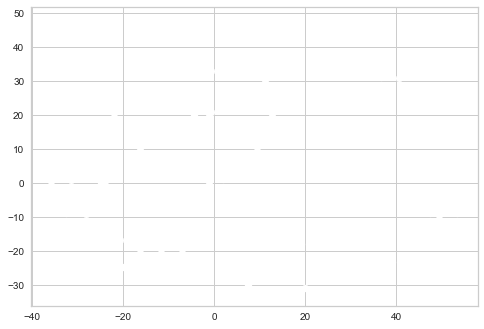

In [86]:
for i, ts in enumerate(df_s):
    XPCAreduced_cl = pca.transform([df_t.values[i]])
    plt.scatter(XPCAreduced_cl[:, 0], XPCAreduced_cl[:, 1], c=clustering.labels_[i])
plt.show()
    

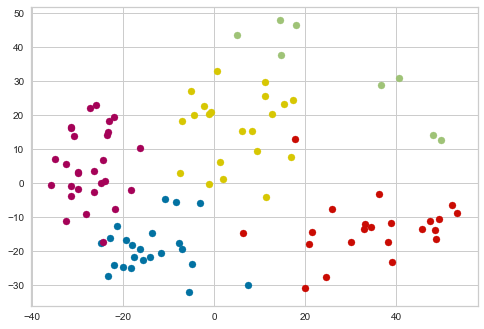

In [89]:
for cl in clusters:
    reg = clusters[cl]
    arr = []
    for reg_num in reg:
        arr.append(df_s[str(reg_num)])
    XPCAreduced_cl = pca.transform(arr)
    plt.scatter(XPCAreduced_cl[:, 0], XPCAreduced_cl[:, 1])
plt.show()

In [87]:
clusters = {k: [] for k in range(5)}
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_t)
#cl_lab = kmeans.predict(df_t)
cl_lab = clustering.labels_
for reg_num in range(len(reg_index)):
    clusters[cl_lab[reg_num]].append(df_t.index[reg_num])

In [88]:
clusters

{0: ['1125',
  '1126',
  '1127',
  '1128',
  '1131',
  '1179',
  '1180',
  '1230',
  '1231',
  '1232',
  '1233',
  '1281',
  '1282',
  '1382',
  '1684',
  '1733',
  '1734',
  '1783',
  '2068',
  '2069',
  '2118',
  '2119',
  '2168'],
 1: ['1480', '1482', '1483', '1530', '1532', '1533', '1580', '1630'],
 2: ['1129',
  '1130',
  '1176',
  '1177',
  '1178',
  '1221',
  '1222',
  '1223',
  '1227',
  '1228',
  '1229',
  '1272',
  '1273',
  '1274',
  '1326',
  '1327',
  '1376',
  '1377',
  '1378',
  '1380',
  '1426',
  '1431'],
 3: ['1075',
  '1076',
  '1077',
  '1132',
  '1181',
  '1184',
  '1234',
  '1235',
  '1279',
  '1280',
  '1283',
  '1284',
  '1285',
  '1286',
  '1287',
  '1331',
  '1332',
  '1333',
  '1334',
  '1335',
  '1336',
  '1337',
  '1338',
  '1383',
  '1384',
  '1385',
  '1386',
  '1434'],
 4: ['1172',
  '1173',
  '1174',
  '1175',
  '1182',
  '1183',
  '1224',
  '1225',
  '1278',
  '1339',
  '1387',
  '1388',
  '1389',
  '1390',
  '1435',
  '1436',
  '1437',
  '1438',
  '14

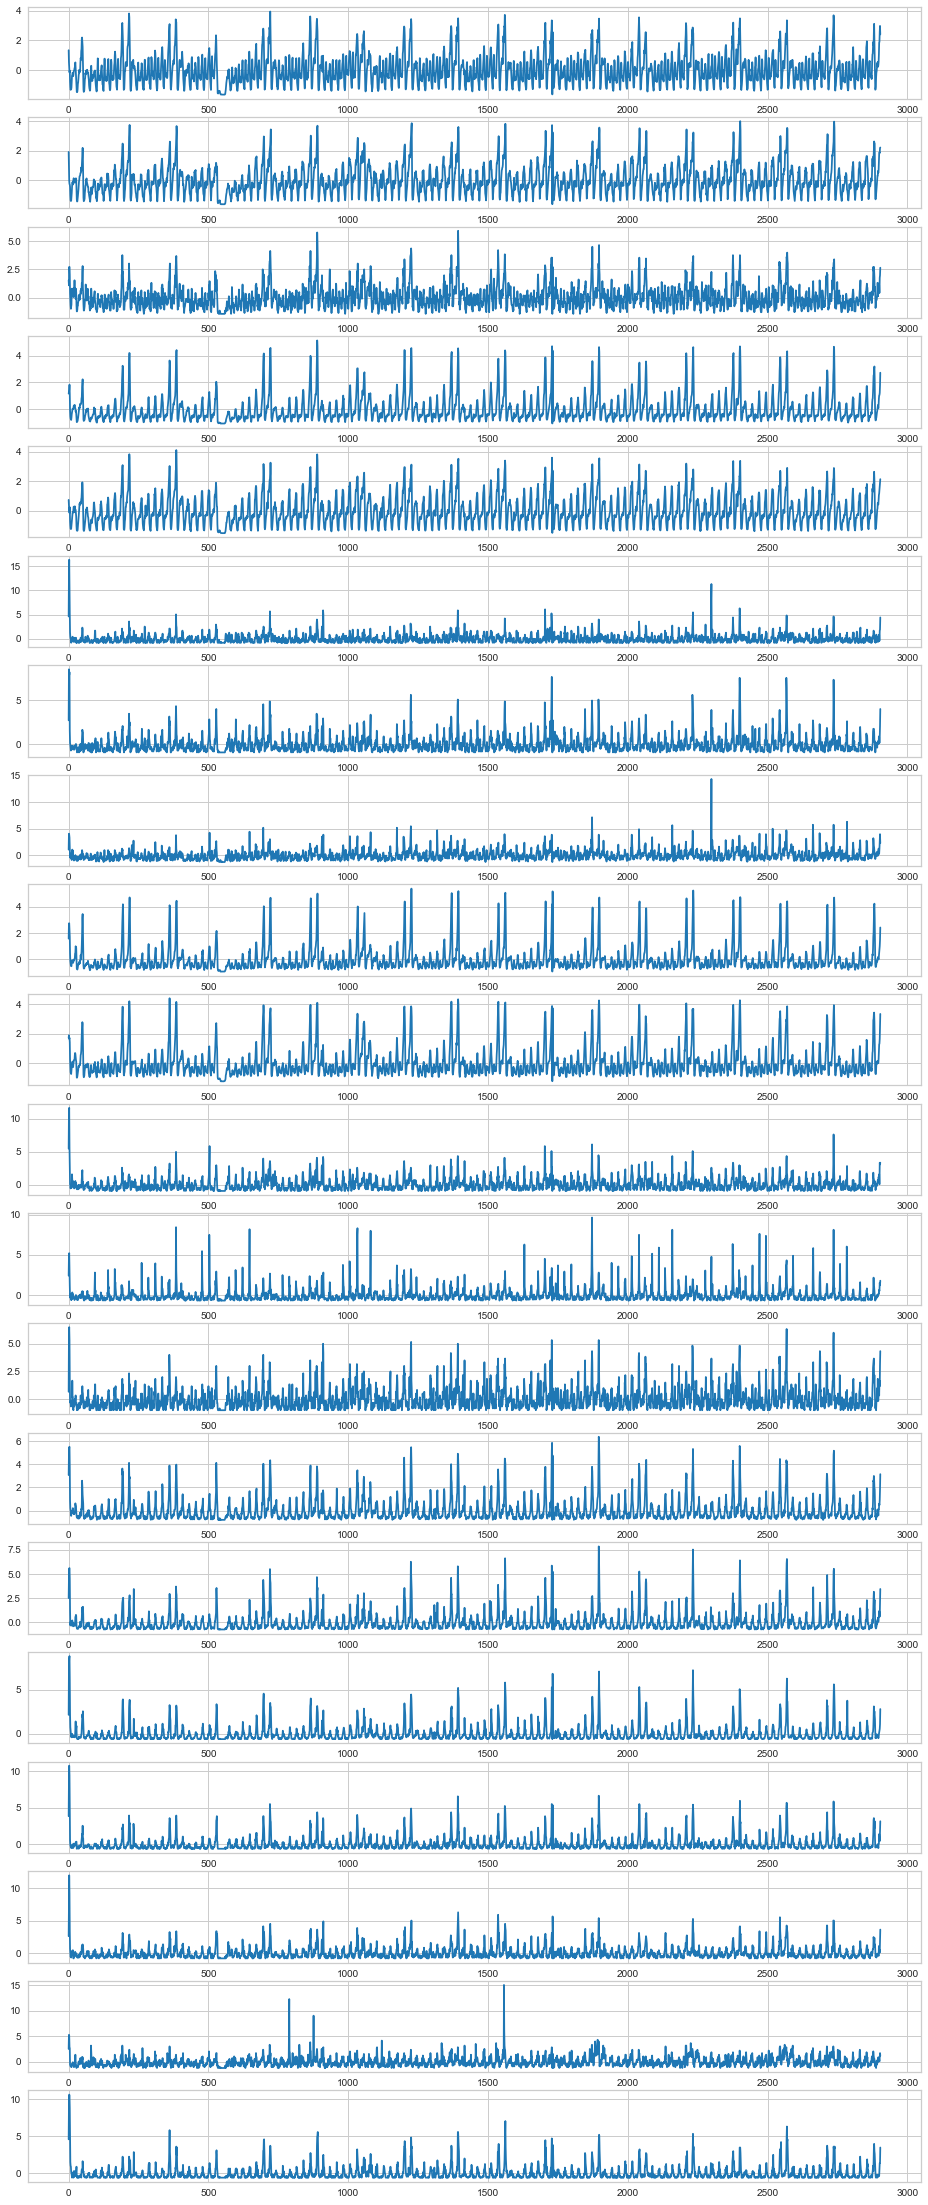

Wall time: 1.38 s


In [60]:
%%time
# отображение стандартизированных рядов
#reg_0 - список регионов из кластера 0
reg = clusters[1]

plt.figure(figsize=(16,len(reg)*2))
for (reg_num, i) in  zip(reg,range(len(reg))) :
    plt.subplot(len(reg),1,i+1)
    plt.plot(df_s[str(reg_num)], color='tab:blue')
plt.show()

###  Задание 4



In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

In [ ]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, df_t)
closest

In [ ]:
inds=df_t.index[closest]
inds

In [ ]:
%%time
n_clust = 6
plt.figure(figsize=(16,12))
for i in  range(n_clust) :
    plt.subplot(n_clust,1,i+1)
    plt.plot(df_s[inds[i]], color='tab:blue')
    
plt.show()

In [ ]:
cluster0 = df_s[inds]


In [ ]:
#cluster0 = cluster0.transpose()
cluster0

###  Задание 5



In [ ]:
def prepair_for_ARIMA(clust,k=51):
    dataset=pd.DataFrame(df[inds[clust]].values,index=df.index, columns={'count'})
    dataset['time'] = df.index
    #cluster0.head()
    w = 168 # длительность недели в часах
    t = np.arange(1, cluster0.shape[0]+1)
    dataset['constant'] = np.ones(cluster0.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin] = np.sin(2*i*np.pi*t/w)
        dataset[cos] = np.cos(2*i*np.pi*t/w)
    #dataset['time'] = pd.to_datetime(cluster0['time'], format='%Y-%m-%d %H:%M:%S')
    #for j in range(wheather.shape[0]):
    #    w='wh_'+str(j)
    #    dataset[w]=0
    #for i in range(dataset.shape[0]):
    #    for j in range(wheather.shape[0]):
    #        w='wh_'+str(j)
    #        if ((dataset['time'].iloc[i].year==wheather[j].year)&(dataset['time'].iloc[i].month==wheather[j].month)&(dataset['time'].iloc[i].day== wheather[j].day)):
    #           dataset[w].iloc[i]=1
    model0=sm.OLS(dataset['count'], dataset.drop(['count','time'], axis=1)).fit()
    print(model0.rsquared_adj)
    print(model0.aic)
    
    return(dataset, model0)

def graph_analysis_for_ARIMA(model):
    resid=pd.DataFrame(model.resid, columns={'resid'}) 
    resid['resid_D24'] = resid.resid - resid.resid.shift(24)
    sm.tsa.seasonal_decompose(resid.resid[0:1000], period=24).plot( )
    sm.tsa.seasonal_decompose(resid.resid_D24[25:1000], period=24).plot( )
    plt.figure(figsize=(16,24))
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax4)
    #plt.show()
    plt.figure(figsize=(16,24))
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax4)
    plt.show()
    print('p-value критерия Дики-Фуллера для ряда остатков =', round(adfuller(resid['resid'])[1], 4))
    print('p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  =', round(adfuller(resid['resid_D24'][24:])[1], 4))



In [ ]:
# визуальный анализ модели для кластера 0
cluster, mod0 =prepair_for_ARIMA(0)
graph_analysis_for_ARIMA(mod0)
#Claster0
#Q0 = 2 q0 = 10
#P0 = 2 p0 = 2

In [ ]:
# визуальный анализ модели для кластера 1
cluster, mod0 =prepair_for_ARIMA(1)
graph_analysis_for_ARIMA(mod0)
#Q0 = 2 q0 = 10
#P0 = 2 p0 = 3

In [ ]:
# визуальный анализ модели для кластера 2
cluster, mod0 =prepair_for_ARIMA(2)
graph_analysis_for_ARIMA(mod0)
#Q0 = 1 q0 = 15
#P0 = 1 p0 = 4

In [ ]:
# визуальный анализ модели для кластера 3
cluster, mod0 =prepair_for_ARIMA(3)
graph_analysis_for_ARIMA(mod0)
#Q0 = 0 q0 = 6
#P0 = 1 p0 = 3

In [ ]:
# визуальный анализ модели для кластера 4
cluster, mod0 =prepair_for_ARIMA(4)
graph_analysis_for_ARIMA(mod0)
#Q0 = 1 q0 = 15
#P0 = 1 p0 = 3

In [ ]:
# визуальный анализ модели для кластера 5
cluster, mod0 =prepair_for_ARIMA(5)
graph_analysis_for_ARIMA(mod0)
#Q0 = 1 q0 = 16
#P0 = 1 p0 = 4

###  Задание 6



In [ ]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=50, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    ans = []
    for (comb,j) in zip(par,range(len(par))):
        print(j)
        try:
            #print("ahahah")
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)
            #print("ohoho")
            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True) 
            #print("sg")
            ans.append([comb,output.aic])
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

In [ ]:
def prepare_param(cluster_num, Q, q, P, p, D=0, d=0, s=24):
    Q0 = range(0, Q)
    q0 = range(0, q)
    P0 = range(0, P)
    p0 = range(0, p)
    D0 =D
    d0 = d
    s0=s
    cluster, mod0 =prepair_for_ARIMA(cluster_num)
    exogen0 = cluster[cluster.columns[2::]]# ваш датасет с экзогенными переменными для представителя кластера 0
    parameters0 = list(product(p0, q0, P0, Q0))
    return parameters0, exogen0

In [ ]:
D = 0
d = 0

In [ ]:
Q0 = 2 
q0 = 10
P0 = 2 
p0 = 2

Q1 = 2
q1 = 8
P1 = 2
p1 = 3

Q2 = 1
q2 = 10
P2 = 1
p2 = 4

Q3 = 1 
q3 = 6
P3 = 1
p3 = 3

Q4 = 1
q4 = 10
P4 = 1
p4 = 3

Q5 = 1
q5 = 10
P5 = 1 
p5 = 4
SARIMA_param = [[Q0, q0, P0, p0], 
                [Q1, q1, P1, p1],
                [Q2, q2, P2, p2],
                [Q3, q3, P3, p3],
                [Q4, q4, P4, p4], 
                [Q5, q5, P5, p5]]

In [ ]:
aic_opt = []
for i in range(6):
    p = SARIMA_param[i]
    parameters0, exogen0 = prepare_param(i, *p)
    print(len(parameters0))
    opt = sarimax_gridsearch(df[inds[0]].transpose() ,exogen0, parameters0, D=D, d=d,freq='H') 
    aic_opt.append(opt)

In [ ]:
i = 5
p = SARIMA_param[i]
parameters0, exogen0 = prepare_param(i, *p)
print(len(parameters0))
opt = sarimax_gridsearch(df[inds[0]].transpose() ,exogen0, parameters0, D=D, d=d,freq='H') 
aic_opt.append(opt)

In [ ]:
for aic in aic_opt:
    print(aic)

In [ ]:
opt_param = [[1, 9, 1, 1],
             [1, 7, 1, 1],
             [2, 9, 0, 0],
             [1, 5, 0, 0],
             [2, 9, 0, 0],
             [2, 9, 0, 0]]

###  Задание 7


In [ ]:
df_5=pd.read_csv("taxi_2016_05.csv")
df_6=pd.read_csv("taxi_2016_06.csv")
df_5.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df_6.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df_5.index=df_5.time
df_6.index=df_6.time
df_5=df_5.iloc[:,nonzero_reg]
df_6=df_6.iloc[:,nonzero_reg]
df_large=pd.concat([ df,df_5,df_6], axis=0)
df_large.head()

In [ ]:
# дальнейшая подготовка данных

In [ ]:
### Кластер 0 до мая

In [ ]:
def prepair_for_train(reg_num, k=21):
    dataset=pd.DataFrame(df_large[str(reg_num)].values,index=df_large.index, columns={'count'})
    dataset['time'] = df_large.index
    #cluster0.head()
    w = 168 # длительность недели в часах
    t = np.arange(1, df_large.shape[0]+1)
    dataset['constant'] = np.ones(df_large.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin] = np.sin(2*i*np.pi*t/w)
        dataset[cos] = np.cos(2*i*np.pi*t/w)

    return dataset

In [ ]:
models = {}
for reg in nonzero_reg.values:
    models[reg] = None

In [ ]:
ind_last = 3648
D = 0
d = 0
s = 24

In [ ]:
for i in range(6):
    reg_in_clst = clusters[i]
    p, q, P, Q = opt_param[i]
    for reg in reg_in_clst:
        print(reg)
        data = prepair_for_train(reg)
        time_series = data['count']
        exogen0 = data[data.columns[2::]]
        models[reg] = sm.tsa.statespace.SARIMAX(time_series[0 :ind_last],exog=exogen0.iloc[0 :ind_last], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)
        

In [ ]:
#p, q, P, Q = opt_param[0]
#reg = 1075
#data = prepair_for_train(reg)
#time_series = data['count']
#exogen0 = data[data.columns[2::]]
#models[reg] = sm.tsa.statespace.SARIMAX(time_series[0 :ind_last],exog=exogen0.iloc[0 :ind_last], order=(p, d, q),
#                               seasonal_order=(P, D, Q, s),
#                               enforce_stationarity=False,
#                               enforce_invertibility=False,freq='H').fit(disp=False)

## Задание 8


In [ ]:
reg_err = {key: 0 for key in reg_index}

In [ ]:
df_large.loc[str(pd.to_datetime(first_hour)):str(pd.to_datetime(six_hour))]['1075']

In [ ]:
pd.to_datetime(start_hour)

In [ ]:
# Ваш код
start_hour = datetime.datetime(2016, 4, 30, 23)
start_plot_hour = start_hour
for reg in reg_index:
    #reg = 1075
    curr_err = 0
    for i in range(739):
        first_hour = start_hour + datetime.timedelta(hours=1)
        six_hour = start_hour + datetime.timedelta(hours=6)
        pred = models[reg].predict(start=first_hour, end=six_hour, dynamic=True)
        true_count = df_large.loc[str(pd.to_datetime(first_hour)):str(pd.to_datetime(six_hour))][str(reg)]
        curr_err += abs(np.array(true_count) - np.array(pred)).sum()
    reg_err[reg] = curr_err/(6*739)

In [ ]:
Q_may = 0
for reg in reg_index:
    Q_may += reg_err[reg]
Q_may  /= len(reg_index)

# Q_may = 19.0446

## Задание 9


In [ ]:
# Ваш код
start_hour = datetime.datetime(2016, 5, 31, 23)
start_plot_hour = start_hour
for reg in reg_index:
    #reg = 1075
    curr_err = 0
    for i in range(715): 
        first_hour = start_hour + datetime.timedelta(hours=1)
        six_hour = start_hour + datetime.timedelta(hours=6)
        pred = models[reg].predict(start=first_hour, end=six_hour, dynamic=True)
        true_count = df_large.loc[str(pd.to_datetime(first_hour)):str(pd.to_datetime(six_hour))][str(reg)]
        curr_err += abs(np.array(true_count) - np.array(pred)).sum()
    reg_err[reg] = curr_err/(6*739)

In [ ]:
Q_june = 0
for reg in reg_index:
    Q_june += reg_err[reg]
Q_june  /= len(reg_index)

# Q_june = 20.0014